In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import optuna
from tqdm.notebook import tqdm
import torchvision

# CLASSIFICATION

## FUNCTIONS

In [2]:
class ClassificationDataset(Dataset):

    def __init__(self, Dataset):
        
        self.transform = torchvision.transforms.ToTensor()
        # Read the file and store the content in a pandas DataFrame
        self.ds = Dataset

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        row = self.ds[idx]
        out = (self.transform(row[0]).flatten() , row[1])
        return out
    
def Kfold(i,s):
    ind = i.copy()
    np.random.shuffle(ind)
    fold = np.array_split(ind,s)
    K = []
    k = [i for i in range(s)]
    for i in k:
        app = k.copy()
        app.pop(i)
        app2 = np.concatenate([fold[j] for j in app])
        K.append([app2,fold[i]])
    return K

In [3]:
class Net(nn.Module):
    def __init__(self, params):#Ni, Nh1, Nh2, Nh3, No):
        
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        Nh3 - Neurons in the 2nd hidden layer
        No - Output size
        
        lr - learning rate
        opt - optimizer
        """
        super().__init__()
        
        #print('Network initialized')
        self.net = nn.Sequential(
            nn.Linear(in_features=784,out_features=params['Nh1']), 
            nn.Sigmoid(), 
            nn.Linear(in_features=params['Nh1'], out_features=params['Nh2']),
            nn.Sigmoid(),
            nn.Linear(in_features=params['Nh2'], out_features=params['Nh3']),
            nn.Sigmoid(),
            nn.Linear(in_features=params['Nh3'], out_features=10))
        
        
        self.optimizer = getattr(optim, params['optimizer'])(self.net.parameters(), 
                                                        lr= params['lr'], weight_decay = params["weight"])
        self.loss_f = nn.CrossEntropyLoss()
        
        self.val_loss = []
        self.train_loss = []
        self.params = params

    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x):
        return self.net(x)

    # Training_step defines the training loop. 
    def train(self, epochs, train_dataloader,val_dataloader,reset = False):

        pbar = tqdm(range(epochs),desc = 'Train loss: ',leave=False)
        for e in pbar:
            train_loss = []
            for x,y in train_dataloader:
                
                #forward
                out = self.forward(x)
                
                #loss
                loss = self.loss_f(out,y)
                
                #backprop
                self.net.zero_grad()
                loss.backward()
                
                #optimizer
                self.optimizer.step()
                
                train_loss.append(loss.detach())
            
            self.train_loss.append(np.mean(train_loss))
            
            val_loss = []
            with torch.no_grad():
                for s in val_dataloader:
                    x = s[0]
                    y = s[1]

                    #forward
                    out = self.forward(x)

                    #loss
                    loss = self.loss_f(out,y)

                    val_loss.append(loss.detach())

            self.val_loss.append(np.mean(val_loss))
            pbar.set_description('Val loss: ' + str(self.val_loss[-1])[:4])
    

def KTrain(params, epochs, train_df, k):
    val_loss = []
    for fold in tqdm(Kfold(np.arange(len(train_df)),k) ,desc= "Fold", leave = False):
        
        train_data = torch.utils.data.Subset(train_df, fold[0])
        val_data = torch.utils.data.Subset(train_df, fold[1])

        batch_size = 2_000
        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=3)
        val_dataloader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
        
        net = Net(params)
        net.train(epochs, train_dataloader, val_dataloader)
        
        val_loss.append(net.val_loss[-1])
        
    return val_loss

## DATASET

In [4]:
train_dataset = ClassificationDataset(torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True))
test_dataset  = ClassificationDataset(torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True))

In [43]:
batch_size = 2_000
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=3)

In [44]:
torch.manual_seed(22)  

params = {
    'Nh1' : 20,
    'Nh2' : 20,
    'Nh3' : 10,
    'lr'  : 1e-2,
    'optimizer': 'Adam',
    'weight': 10**(-3)
    }
net = Net(params)
epochs = 50
net.train(epochs, train_dataloader, test_dataloader)
print("DONE")
print("Test error = ", net.val_loss[-1])

Train loss:   0%|          | 0/50 [00:00<?, ?it/s]

DONE
Test error =  0.47979322


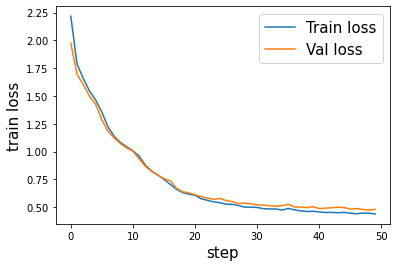

In [47]:
plt.plot(net.train_loss, label = 'Train loss')
plt.plot(net.val_loss, label = 'Val loss')
plt.xlabel('step',fontsize=15)
plt.ylabel('train loss',fontsize=15)
plt.legend(fontsize=15)

plt.savefig('NN_cl_test.png', dpi = 200)

In [46]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')


Accuracy of the network on the test images: 84 %


## HYPERPARAMETER OPTIMIZATION

In [27]:
torch.manual_seed(201098)  

def objective(trial):
    # Parameters
    params = {
    'Nh1' : trial.suggest_int('Nh1', 20,50),
    'Nh2' : trial.suggest_int('Nh2', 20,50),
    'Nh3' : trial.suggest_int('Nh3', 10,30),
    'lr'  : trial.suggest_loguniform('lr', 1e-4, 1e-2),
    'weight'  : trial.suggest_loguniform('weight', 1e-4, 1e-1),
    'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    }
    epochs = 30
    val_loss = KTrain(params, epochs, train_dataset, 3)
    
    return np.mean(val_loss)

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()

study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=10)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-01 15:32:51,599] A new study created in memory with name: myfirstoptimizationstudy


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-07-01 15:40:16,968] Trial 0 finished with value: 2.338595390319824 and parameters: {'Nh1': 46, 'Nh2': 50, 'Nh3': 16, 'lr': 0.0001321670335249159, 'weight': 0.005296209173801351, 'optimizer': 'SGD'}. Best is trial 0 with value: 2.338595390319824.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-07-01 15:47:37,773] Trial 1 finished with value: 2.3032591342926025 and parameters: {'Nh1': 34, 'Nh2': 25, 'Nh3': 25, 'lr': 0.004498189538332885, 'weight': 0.019350273023923448, 'optimizer': 'Adam'}. Best is trial 1 with value: 2.3032591342926025.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-07-01 15:55:05,912] Trial 2 finished with value: 2.3037426471710205 and parameters: {'Nh1': 50, 'Nh2': 35, 'Nh3': 30, 'lr': 0.0053402308456828645, 'weight': 0.032964921393482595, 'optimizer': 'Adam'}. Best is trial 1 with value: 2.3032591342926025.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-07-01 16:02:22,737] Trial 3 finished with value: 2.30383563041687 and parameters: {'Nh1': 20, 'Nh2': 36, 'Nh3': 24, 'lr': 0.005095310371558952, 'weight': 0.00020194555916966124, 'optimizer': 'SGD'}. Best is trial 1 with value: 2.3032591342926025.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-07-01 16:09:37,535] Trial 4 finished with value: 2.314436912536621 and parameters: {'Nh1': 21, 'Nh2': 23, 'Nh3': 20, 'lr': 0.0013852609243538254, 'weight': 0.010883118085151766, 'optimizer': 'SGD'}. Best is trial 1 with value: 2.3032591342926025.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-07-01 16:17:05,034] Trial 5 finished with value: 0.7523583769798279 and parameters: {'Nh1': 50, 'Nh2': 24, 'Nh3': 13, 'lr': 0.0035828565139417036, 'weight': 0.001303915422798113, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.7523583769798279.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-07-01 16:24:30,028] Trial 6 finished with value: 2.3027217388153076 and parameters: {'Nh1': 46, 'Nh2': 32, 'Nh3': 17, 'lr': 0.009168679054093168, 'weight': 0.0029298517050014438, 'optimizer': 'SGD'}. Best is trial 5 with value: 0.7523583769798279.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-07-01 16:31:56,453] Trial 7 finished with value: 0.6009668707847595 and parameters: {'Nh1': 49, 'Nh2': 23, 'Nh3': 24, 'lr': 0.0021494474060276404, 'weight': 0.00015566199342397332, 'optimizer': 'Adam'}. Best is trial 7 with value: 0.6009668707847595.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-07-01 16:39:19,735] Trial 8 finished with value: 2.3033525943756104 and parameters: {'Nh1': 46, 'Nh2': 30, 'Nh3': 17, 'lr': 0.0001001571339452963, 'weight': 0.04734975105228667, 'optimizer': 'RMSprop'}. Best is trial 7 with value: 0.6009668707847595.


Fold:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

Train loss:   0%|          | 0/30 [00:00<?, ?it/s]

[I 2022-07-01 16:46:41,827] Trial 9 finished with value: 2.310465097427368 and parameters: {'Nh1': 43, 'Nh2': 37, 'Nh3': 19, 'lr': 0.0024859949797671234, 'weight': 0.007067187682121127, 'optimizer': 'SGD'}. Best is trial 7 with value: 0.6009668707847595.


Number of finished trials: 10
Best trial:
  Value: 0.6009668707847595
  Params: 
    Nh1: 49
    Nh2: 23
    Nh3: 24
    lr: 0.0021494474060276404
    weight: 0.00015566199342397332
    optimizer: Adam


## BEST MODEL

In [29]:
params = trial.params

net = Net(params)
print(params)
epochs = 100
net.train(epochs, train_dataloader, test_dataloader)
print("DONE")
print("Test error = ", net.val_loss[-1])

{'Nh1': 49, 'Nh2': 23, 'Nh3': 24, 'lr': 0.0021494474060276404, 'weight': 0.00015566199342397332, 'optimizer': 'Adam'}


Train loss:   0%|          | 0/100 [00:00<?, ?it/s]

DONE
Test error =  0.35473266


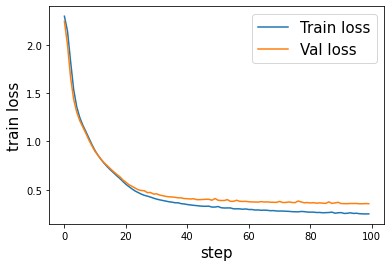

In [38]:
plt.plot(net.train_loss, label = 'Train loss')
plt.plot(net.val_loss, label = 'Val loss')
plt.xlabel('step',fontsize=15)
plt.ylabel('train loss',fontsize=15)
plt.legend(fontsize=15)

plt.savefig('NN_cl_best.png', dpi = 200)

In [39]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')


Accuracy of the network on the test images: 87 %


## WEIGHT HISTOGRAMS

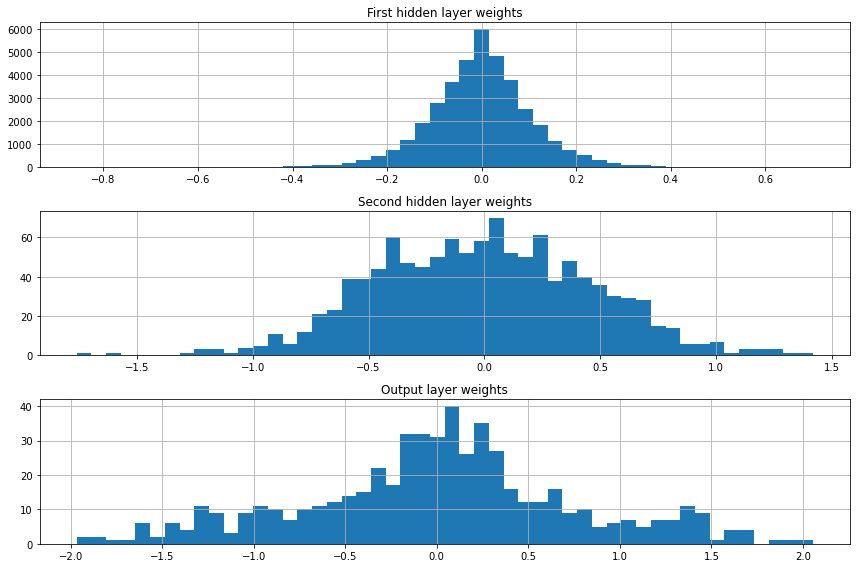

<Figure size 432x288 with 0 Axes>

In [41]:
# First hidden layer
h1_w = net.net[0].weight.data.cpu().numpy()
h1_b = net.net[0].bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.net[2].weight.data.cpu().numpy()
h2_b = net.net[2].bias.data.cpu().numpy()

# Output layer
h3_w = net.net[4].weight.data.cpu().numpy()
h3_b = net.net[4].bias.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

plt.savefig('NN_cl_best_act.png', dpi = 200)